<a href="https://colab.research.google.com/github/salonisahu1999/Bitcoinpriceprediction/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%pip install tensorflow-addons

In [7]:
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape
import tensorflow as tf
#from scipy.ndimage import imread
import numpy as np
import random
from keras.layers import GRU, CuDNNGRU
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
#from keras.backend.tensorflow_backend import set_session
from keras import optimizers
from math import sqrt
from numpy import concatenate
from  matplotlib import pyplot 
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
py.init_notebook_mode(connected=True)
from scipy import stats
from tensorflow import keras
import tensorflow_addons as tfa
from prettytable import PrettyTable


%matplotlib inline

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data = pd.read_csv(filepath_or_buffer="/content/BTC-USD (3).csv", index_col="Date")

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 917 entries, 2019-01-01 to 2021-07-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       913 non-null    float64
 1   High       913 non-null    float64
 2   Low        913 non-null    float64
 3   Close      913 non-null    float64
 4   Adj Close  913 non-null    float64
 5   Volume     913 non-null    float64
dtypes: float64(6)
memory usage: 50.1+ KB


In [11]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09


In [12]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-01,35035.984375,35035.984375,32883.781250,33572.117188,33572.117188,3.783896e+10
2021-07-02,33549.601563,33939.589844,32770.679688,33897.046875,33897.046875,3.872897e+10
2021-07-03,33854.421875,34909.261719,33402.695313,34668.546875,34668.546875,2.438396e+10
2021-07-04,34665.566406,35937.566406,34396.476563,35287.781250,35287.781250,2.492431e+10
2021-07-05,34930.460938,34990.582031,34129.914063,34246.839844,34246.839844,2.435889e+10


In [13]:
btc_trace = go.Scatter(x=data.index, y=data['Adj Close'], name= 'Price')
py.iplot([btc_trace])

In [14]:
data['Adj Close'].replace(0, np.nan, inplace=True)
data['Adj Close'].fillna(method='ffill', inplace=True)

In [15]:
#btc_trace = go.Scatter(x=data.index, y=data['Adj Close'], name= 'Price')
#py.iplot([btc_trace])

In [16]:
from sklearn.preprocessing import MinMaxScaler

values = data['Adj Close'].values.reshape(-1,1)
values = values.astype(float)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [17]:
print(scaled)

[[7.38800160e-03]
 [9.04994471e-03]
 [7.27521692e-03]
 [7.62421737e-03]
 [7.41586265e-03]
 [1.12664890e-02]
 [1.04115660e-02]
 [1.05047314e-02]
 [1.05787445e-02]
 [4.64949004e-03]
 [4.78992861e-03]
 [4.35627261e-03]
 [2.55359847e-03]
 [5.10083590e-03]
 [3.84672683e-03]
 [4.25155095e-03]
 [4.64349050e-03]
 [4.29867792e-03]
 [5.47545520e-03]
 [3.35322177e-03]
 [2.93758875e-03]
 [3.41251028e-03]
 [3.08883622e-03]
 [3.35075616e-03]
 [3.33246103e-03]
 [3.37729300e-03]
 [3.06958247e-03]
 [1.18093266e-03]
 [8.09351705e-04]
 [1.44266575e-03]
 [9.70335738e-04]
 [1.47200943e-03]
 [2.02297918e-03]
 [1.07383475e-03]
 [9.92985285e-04]
 [1.11283373e-03]
 [2.37856806e-04]
 [0.00000000e+00]
 [4.44743541e-03]
 [4.52103020e-03]
 [4.83689310e-03]
 [4.14213771e-03]
 [4.22695571e-03]
 [3.86994100e-03]
 [3.61721736e-03]
 [3.68260290e-03]
 [3.83195751e-03]
 [4.56483044e-03]
 [8.58915881e-03]
 [9.11125608e-03]
 [9.98850365e-03]
 [9.22811492e-03]
 [1.00834400e-02]
 [1.23628270e-02]
 [6.83741365e-03]
 [8.039809

In [18]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

641 276


In [19]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [20]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

640
275


In [21]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [22]:
print(trainX.shape)
print(testX.shape)

(640, 1, 1)
(275, 1, 1)


In [23]:
model_adam = Sequential()
model_adam.add(LSTM(100,return_sequences=True,input_shape=(trainX.shape[1], trainX.shape[2])))
model_adam.add(Dropout(0.2))
for i in[True,False]:
    model_adam.add(LSTM(100,return_sequences=i))
    model_adam.add(Dropout(0.2))
model_adam.add(Dense(1))
model_adam.compile(optimizer='adam',loss='mean_squared_error',metrics=["mean_squared_error"])
history_adam= model_adam.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))


In [24]:
test_results_loss = []
test_results_r2score = []
test_results_loss.append(model_adam.evaluate(
    testX, testY, verbose=0))

model_predict = model_adam.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

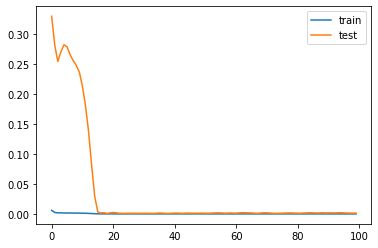

In [25]:
pyplot.plot(history_adam.history['loss'], label='train')
pyplot.plot(history_adam.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

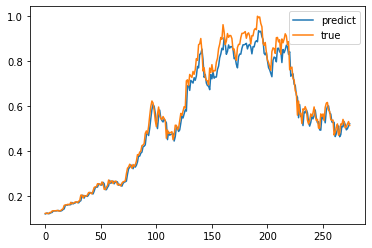

In [26]:
yhat = model_adam.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()


In [27]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

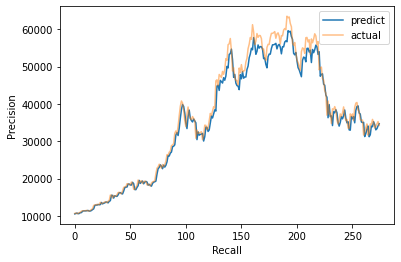

In [28]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [29]:
predictDates = data.tail(len(testX)).index

In [30]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [31]:
print(testY_reshape)

[10684.428711 10804.000977 10621.664063 10679.136719 10923.62793
 10923.62793  11296.361328 11384.181641 11384.181641 11384.181641
 11429.506836 11495.349609 11322.123047 11358.101563 11483.359375
 11742.037109 11916.334961 12823.689453 12965.891602 12931.539063
 13108.0625   13031.173828 13075.248047 13654.21875  13271.285156
 13437.882813 13546.522461 13780.995117 13737.109375 13550.489258
 13950.300781 14133.707031 15579.848633 15565.880859 14833.753906
 15479.567383 15332.31543  15290.902344 15701.339844 16276.34375
 16317.808594 16068.138672 15955.587891 16716.111328 17645.40625
 17804.005859 17817.089844 18621.314453 18642.232422 18370.001953
 18364.121094 19107.464844 18732.121094 17150.623047 17108.402344
 17717.414063 18177.484375 19625.835938 18802.998047 19201.091797
 19445.398438 18699.765625 19154.230469 19345.121094 19191.630859
 18321.144531 18553.916016 18264.992188 18058.904297 18803.65625
 19142.382813 19246.644531 19417.076172 21310.597656 22805.162109
 23137.960938 

In [32]:
print(yhat_reshape)

[10548.324  10666.606  10785.519  10604.1875 10661.343  10904.48
 10904.48   11275.109  11362.427  11362.427  11362.427  11407.492
 11472.954  11300.724  11336.496  11461.033  11718.204  11891.47
 12793.212  12934.493  12900.364  13075.73   12999.348  13043.133
 13618.186  13237.868  13403.34   13511.234  13744.072  13700.496
 13515.175  13912.174  14094.251  15528.935  15515.087  14788.979
 15429.509  15283.498  15242.428  15649.376  16219.212  16260.288
 16012.917  15901.382  16654.785  17574.482  17731.338  17744.275
 18539.13   18559.795  18290.842  18285.03   19019.182  18648.576
 17084.94   17043.152  17645.701  18100.58   19530.666  18718.574
 19111.594  19352.672  18616.621  19065.342  19253.729  19102.258
 18242.56   18472.553  18187.066  17983.367  18719.223  19053.648
 19156.555  19324.727  21190.078  22657.955  22984.229  23700.947
 23316.676  22655.918  23616.     23085.537  23569.918  24478.16
 26205.684  26045.414  26835.219  27104.705  28536.453  28691.777
 29051.326  3

In [33]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])
# pyplot.show()

In [36]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-01,35035.984375,35035.984375,32883.781250,33572.117188,33572.117188,3.783896e+10
2021-07-02,33549.601563,33939.589844,32770.679688,33897.046875,33897.046875,3.872897e+10
2021-07-03,33854.421875,34909.261719,33402.695313,34668.546875,34668.546875,2.438396e+10
2021-07-04,34665.566406,35937.566406,34396.476563,35287.781250,35287.781250,2.492431e+10
2021-07-05,34930.460938,34990.582031,34129.914063,34246.839844,34246.839844,2.435889e+10


In [37]:
model_sgd = Sequential()
model_sgd.add(LSTM(100,return_sequences=True,input_shape=(trainX.shape[1], trainX.shape[2])))
model_sgd.add(Dropout(0.2))
for i in[True,False]:
    model_sgd.add(LSTM(100,return_sequences=i))
    model_sgd.add(Dropout(0.2))
model_sgd.add(Dense(1))
model_sgd.compile(optimizer='sgd',loss='mean_squared_error')
history_sgd= model_sgd.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))

In [38]:
test_results_loss.append(model_sgd.evaluate(
    testX, testY, verbose=0))

model_predict = model_sgd.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

In [39]:
model_adagrad = Sequential()
model_adagrad.add(LSTM(100,return_sequences=True,input_shape=(trainX.shape[1], trainX.shape[2])))
model_adagrad.add(Dropout(0.2))
for i in[True,False]:
    model_adagrad.add(LSTM(100,return_sequences=i))
    model_adagrad.add(Dropout(0.2))
model_adagrad.add(Dense(1))
model_adagrad.compile(optimizer='adagrad',loss='mean_squared_error')
history_adagrad= model_adagrad.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))

In [40]:
test_results_loss.append(model_adagrad.evaluate(
    testX, testY, verbose=0))

model_predict = model_adagrad.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

In [41]:
model_rmsprop = Sequential()
model_rmsprop.add(LSTM(100,return_sequences=True,input_shape=(trainX.shape[1], trainX.shape[2])))
model_rmsprop.add(Dropout(0.2))
for i in[True,False]:
    model_rmsprop.add(LSTM(100,return_sequences=i))
    model_rmsprop.add(Dropout(0.2))
model_rmsprop.add(Dense(1))
model_rmsprop.compile(optimizer='rmsprop',loss='mean_squared_error')
history_rmsprop= model_rmsprop.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))

In [42]:
test_results_loss.append(model_rmsprop.evaluate(
    testX, testY, verbose=0))

model_predict = model_rmsprop.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

In [43]:
model_adadelta = Sequential()
model_adadelta.add(LSTM(100,return_sequences=True,input_shape=(trainX.shape[1], trainX.shape[2])))
model_adadelta.add(Dropout(0.2))
for i in[True,False]:
    model_adadelta.add(LSTM(100,return_sequences=i))
    model_adadelta.add(Dropout(0.2))
model_adadelta.add(Dense(1))
model_adadelta.compile( optimizer='adadelta',loss='mean_squared_error')
history_adadelta= model_adadelta.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))

In [44]:
test_results_loss.append(model_adadelta.evaluate(
    testX, testY, verbose=0))

model_predict = model_adadelta.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

In [45]:
model_nadam = Sequential()
model_nadam.add(LSTM(100,return_sequences=True,input_shape=(trainX.shape[1], trainX.shape[2])))
model_nadam.add(Dropout(0.2))
for i in[True,False]:
    model_nadam.add(LSTM(100,return_sequences=i))
    model_nadam.add(Dropout(0.2))
model_nadam.add(Dense(1))
model_nadam.compile(optimizer='nadam',loss='mean_squared_error')
history_nadam= model_nadam.fit(trainX, trainY, epochs=100, batch_size=100,verbose=0, validation_data=(testX, testY))

In [46]:
test_results_loss.append(model_nadam.evaluate(
    testX, testY, verbose=0))

model_predict = model_nadam.predict(testX).flatten()
metric = tfa.metrics.r_square.RSquare()
metric.update_state(model_predict, testY)
test_results_r2score.append(metric.result().numpy())

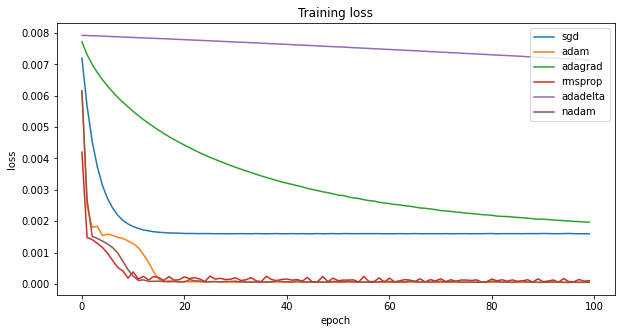

In [47]:
pyplot.figure(figsize=(10, 5))  

pyplot.plot(history_sgd.history['loss'])  
pyplot.plot(history_adam.history['loss']) 
pyplot.plot(history_adagrad.history['loss'])
pyplot.plot(history_rmsprop.history['loss'])
pyplot.plot(history_adadelta.history['loss'])
pyplot.plot(history_nadam.history['loss'])  
pyplot.title('Training loss')  
pyplot.ylabel('loss')  
pyplot.xlabel('epoch') 
pyplot.legend(['sgd','adam','adagrad','rmsprop','adadelta','nadam'], loc='upper right')  

pyplot.show()

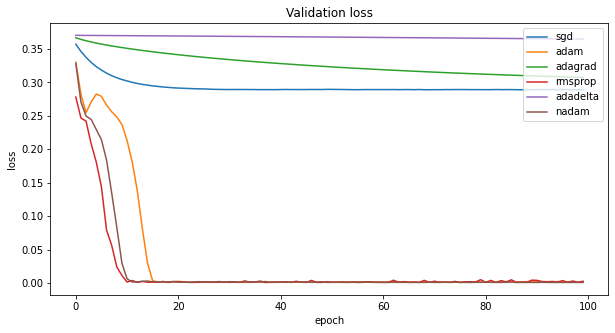

In [48]:
pyplot.figure(figsize=(10, 5))  

pyplot.plot(history_sgd.history['val_loss'])  
pyplot.plot(history_adam.history['val_loss']) 
pyplot.plot(history_adagrad.history['val_loss'])
pyplot.plot(history_rmsprop.history['val_loss'])
pyplot.plot(history_adadelta.history['val_loss'])
pyplot.plot(history_nadam.history['val_loss'])  
pyplot.title('Validation loss')  
pyplot.ylabel('loss')  
pyplot.xlabel('epoch') 
pyplot.legend(['sgd','adam','adagrad','rmsprop','adadelta','nadam'], loc='upper right')  

pyplot.show()

In [49]:
optimizers = ['Adam','SGD','Adagrad','RmsProp','Adadelta','Nadam']
t = PrettyTable(['Optimizers', 'MSE', 'RSquare'])

#Loop to display the predictor combinations along with the MSE value of the corresponding model
for i in range(len(test_results_loss)):
    t.add_row([optimizers[i],test_results_loss[i],test_results_r2score[i]])
print(t)

+------------+------------------------------------------------+-------------+
| Optimizers |                      MSE                       |   RSquare   |
+------------+------------------------------------------------+-------------+
|    Adam    | [0.0014425456756725907, 0.0014425456756725907] |  0.97677416 |
|    SGD     |               0.2890929877758026               |  -2215610.5 |
|  Adagrad   |              0.30742326378822327               |  -4404872.5 |
|  RmsProp   |              0.002660730853676796              |  0.9541223  |
|  Adadelta  |               0.3648220896720886               | -20978444.0 |
|   Nadam    |             0.0008823326788842678              |  0.9873445  |
+------------+------------------------------------------------+-------------+


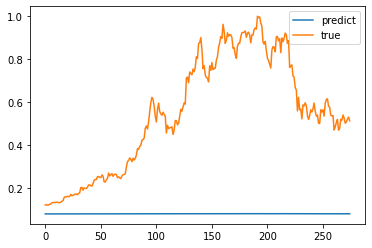

In [50]:
#SGD
yhat = model_sgd.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [51]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

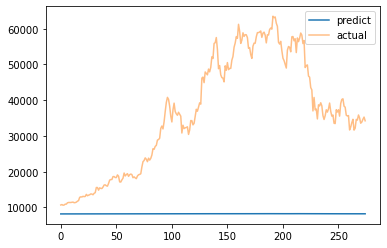

In [52]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

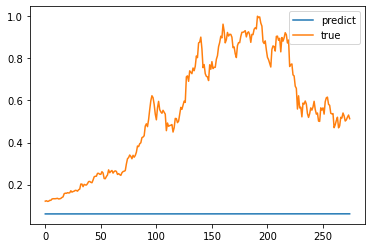

In [53]:
#ADAGRAD
yhat = model_adagrad.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [54]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

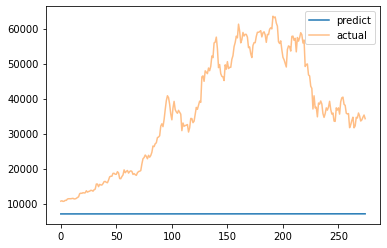

In [55]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

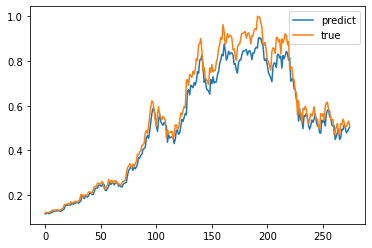

In [56]:
#RMSPROP
yhat = model_rmsprop.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [57]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

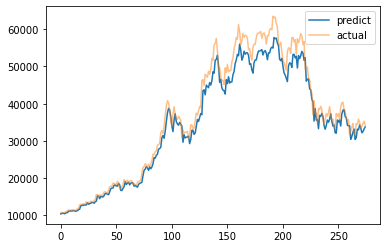

In [58]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

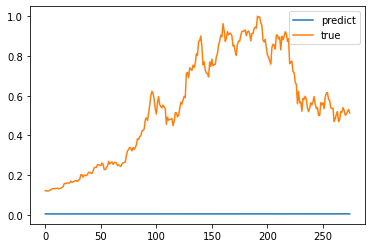

In [59]:
#ADADELTA
yhat = model_adadelta.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [60]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

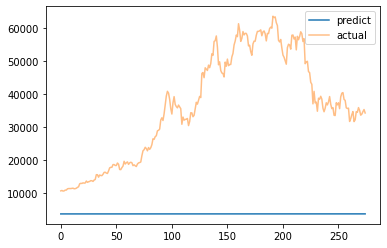

In [61]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

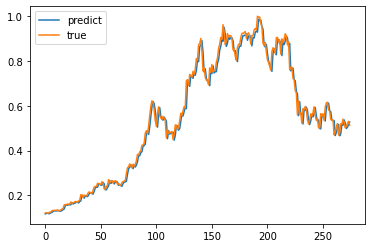

In [62]:
#NADAM
yhat = model_nadam.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [63]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

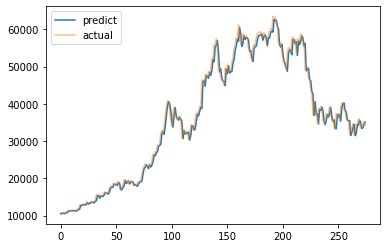

In [64]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()